# Piggybacking Experiment

In [1]:
import subprocess
import os
print('Current conda environment:', os.environ['CONDA_DEFAULT_ENV'])

cwd = os.getcwd()
print(cwd)

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(42)

Current conda environment: reinvent
/home/fts_g_ucla_edu/Projects/rips-relay/experiments


In [17]:
import pandas as pd

from crem.crem import grow_mol, mutate_mol
crem_db = '../crem_db/crem_db2.5.db'

import mols2grid

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import PandasTools
from rdkit import DataStructs

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})

In [3]:
fragment_lead_pairs = pd.read_csv('data/fragment_lead_pairs.csv')

fragment_lead_pairs.head()

,Year,Table_Entry,Fragment,Lead
0,2022,1,Nc1cc(c[nH]c1=O)C(F)(F)F,N[C@H]1CCN(Cc2cccc(c2)c3ccc4c(=O)[nH]ccc4c3)C1
1,2022,2,CN1C[C@@H](O)[C@H](C1=O)c2ccc(C)cc2,COc1ccc(CN2C[C@H](O)[C@](CCC(C)C)(C2=O)c3ccc(c...
2,2022,3,Fc1cncc(c1)N2C(=O)N[C@@H](Cc3ccccc3)C2=O,Clc1ccccc1C2CC3(C2)NC(=O)N(C3=O)c4cncc5ccccc45
3,2022,4,c1ccc(cc1)c2ccccc2c3nnn[nH]3,Cc1ccc(cc1)c2cccc(c2c3nnn[nH]3)S(=O)(=O)N
4,2022,5,CN(C)C(=O)C(N)Cc1ccc(F)cc1,Clc1ccc(cc1)[C@H]2CN[C@H](C2)C(=O)N3CCN(CC3)c4...


In [4]:
def tanimoto_similarity(smi_1, smi_2, use_counts=True):
    fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048,countSimulation=True)
    mol_1 = Chem.MolFromSmiles(smi_1)
    mol_2 = Chem.MolFromSmiles(smi_2)
    if use_counts:
        fp_1 = rdFingerprintGenerator.GetCountFPs([mol_1])[0]
        fp_2 = rdFingerprintGenerator.GetCountFPs([mol_2])[0]
    else:
        fp_1 = rdFingerprintGenerator.GetFPs([mol_1])[0]
        fp_2 = rdFingerprintGenerator.GetFPs([mol_2])[0]
    return DataStructs.TanimotoSimilarity(fp_1, fp_2)

In [5]:
def piggyback(initial, lead, mol_list, dataframes, model='reinvent'):

    initial_mol = Chem.MolFromSmiles(initial)
    results = {}    # Temporary dict to store results per-run

    if model == 'reinvent': # Generate analogs w/ REINVENT

        # Change directory to run python script
        %cd ..

        arg1 = f'--input_frag'
        subprocess.run(['python3', 'generate_analogs.py', arg1, initial],
                    stdout=subprocess.DEVNULL,
                    stderr=subprocess.STDOUT)
        
        # Change directory back to that of the current notebook
        %cd experiments
        
        # Read dataframe
        df = pd.read_csv('data/dataframe.csv')
        df.drop(['Unnamed: 0'], axis=1, inplace=True)
    
    elif model == 'crem':   # Generate analogs w/ CReM
        
        out_list = []
        mutate_list = list(mutate_mol(initial_mol, db_name=crem_db, return_mol=False))

        for idx, analog in enumerate(mutate_list):
            out_list.append([analog, initial])

        df = pd.DataFrame(out_list, columns=["SMILES","Input_SMILES"])

    else:   # Raise an error if an invalid model is entered
        raise Exception('Invalid Model')
    
    # Remove duplicate values
    df.drop_duplicates(inplace=True, ignore_index=True, subset=['SMILES'])
    
    # Remove the initial fragment from the generated distribution
    if initial in df['SMILES'].values:

        index = df.loc[df['Tanimoto'] == 1].index[0]
        df.drop(index)

    df.round(3)

    dataframes.append(df)

    # Compute similarities to lead molecule
    similarities_to_lead = [tanimoto_similarity(analog, lead, True) for analog in df['SMILES'].values]
    df['sim_to_lead'] = similarities_to_lead
    df.sort_values('sim_to_lead', ascending=False, inplace=True)

    # Calculate mean and max Tanimoto similarities
    results['mean'], results['max'], results['num_analogs'] = [df['sim_to_lead'].mean()], [df['sim_to_lead'].max()], len(df)
    

    if len(df) > 0:
        # Find SMILES string corresponding to best value
        best = df['SMILES'].values[0]
        
        # Add best to list of piggybacked molecules
        mol_list.append(Chem.MolFromSmiles(best))
    else:
        best = None

    return best, mol_list, results, dataframes

In [6]:
def run_experiment(initial, lead, model='reinvent', max_iters=10):

    dataframes = []
    best = initial
    best_tanimoto = tanimoto_similarity(initial, lead)
    n_iters = 0
    mol_list = [Chem.MolFromSmiles(initial)]
    results_df = pd.DataFrame()

    while best_tanimoto < 1.0 and n_iters < max_iters:

        n_iters += 1

        print(f'\n ===   Iteration: {n_iters}   === \n')

        best, mol_list, results, dataframes = piggyback(best, lead, mol_list, dataframes, model)

        if best == None:
            print('Empty Dataframe')
            break

        temp_df = pd.DataFrame(data=results)

        results_df = pd.concat((results_df, temp_df))

        if best_tanimoto == results['max'][0]:
            print(f'GOT STUCK: {best_tanimoto}')
            break
        else:
            best_tanimoto = results['max'][0]
        
        print(f'\n ===   CURRENT BEST: {best_tanimoto}   === \n')

    mol_list.append(Chem.MolFromSmiles(lead))

    return results_df, mol_list, dataframes

### Exploring representative fragment-lead pairs

In [7]:
%%capture

i = 0

initial, lead = fragment_lead_pairs['Fragment'][i], fragment_lead_pairs['Lead'][i]
            
results_df, mol_list, dataframes = run_experiment(initial, lead)

In [8]:
mols2grid.display(mol_list, size=(300, 250))

MolGridWidget()

In [9]:
for i, df in enumerate(dataframes):

    max = results_df['max'].values[i]
    mean = results_df['mean'].values[i]

    print(f' === Distribution: {i} === \n')
    print(f'Best similarity to lead: {max}')
    print(f'Average similarity to lead: {mean}')
    print(f'Size of distribution: {len(df)}\n\n')

 === Distribution: 0 === 

Best similarity to lead: 0.3176470588235294
Average similarity to lead: 0.12847679238366705
Size of distribution: 771


 === Distribution: 1 === 

Best similarity to lead: 0.4
Average similarity to lead: 0.26719506344772115
Size of distribution: 729


 === Distribution: 2 === 

Best similarity to lead: 0.4810126582278481
Average similarity to lead: 0.3239719889385351
Size of distribution: 801


 === Distribution: 3 === 

Best similarity to lead: 0.5384615384615384
Average similarity to lead: 0.36346953873181154
Size of distribution: 752


 === Distribution: 4 === 

Best similarity to lead: 0.8
Average similarity to lead: 0.3839381298160757
Size of distribution: 779


 === Distribution: 5 === 

Best similarity to lead: 0.8
Average similarity to lead: 0.5488941795859561
Size of distribution: 863




In [10]:
num_distributions = len(dataframes)

for i in range(num_distributions - 1):

    df1, df2 = dataframes[i], dataframes[i+1]

    int_df = pd.merge(df1, df2, how='inner', on=['SMILES'])
    union_df = pd.merge(df1, df2, how='outer', on=['SMILES'])

    int_size = len(int_df)
    union_size = len(union_df)

    sim_score = int_size / union_size

    print(f'Size of intersection between distribution {i} and {i+1}: {int_size}')
    print(f'Similarity score: {sim_score}')
    print()

Size of intersection between distribution 0 and 1: 8
Similarity score: 0.005361930294906166

Size of intersection between distribution 1 and 2: 70
Similarity score: 0.04794520547945205

Size of intersection between distribution 2 and 3: 31
Similarity score: 0.020367936925098553

Size of intersection between distribution 3 and 4: 412
Similarity score: 0.3681858802502234

Size of intersection between distribution 4 and 5: 40
Similarity score: 0.024968789013732832



### Visualizing each distribution

In [11]:
for i, df in enumerate(dataframes):
    df['Distribution'] = i

df = pd.concat(dataframes)

In [12]:
smiles = df['SMILES'].values
mols = [Chem.MolFromSmiles(smile) for smile in smiles]

fpgen = AllChem.GetMorganGenerator()
fingerprints = [fpgen.GetFingerprint(mol) for mol in mols]

X = fingerprints

In [13]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [14]:
pca = PCA(n_components=3, random_state=0)
pca_fps = pca.fit_transform(X)

In [24]:
pca.explained_variance_ratio_

array([0.01269652, 0.01061269, 0.00659136])

In [15]:
df['PC1'], df['PC2'], df['PC3'] = pca_fps.T[0], pca_fps.T[1], pca_fps.T[2]

In [16]:
plot_df = df.sample(n=500)

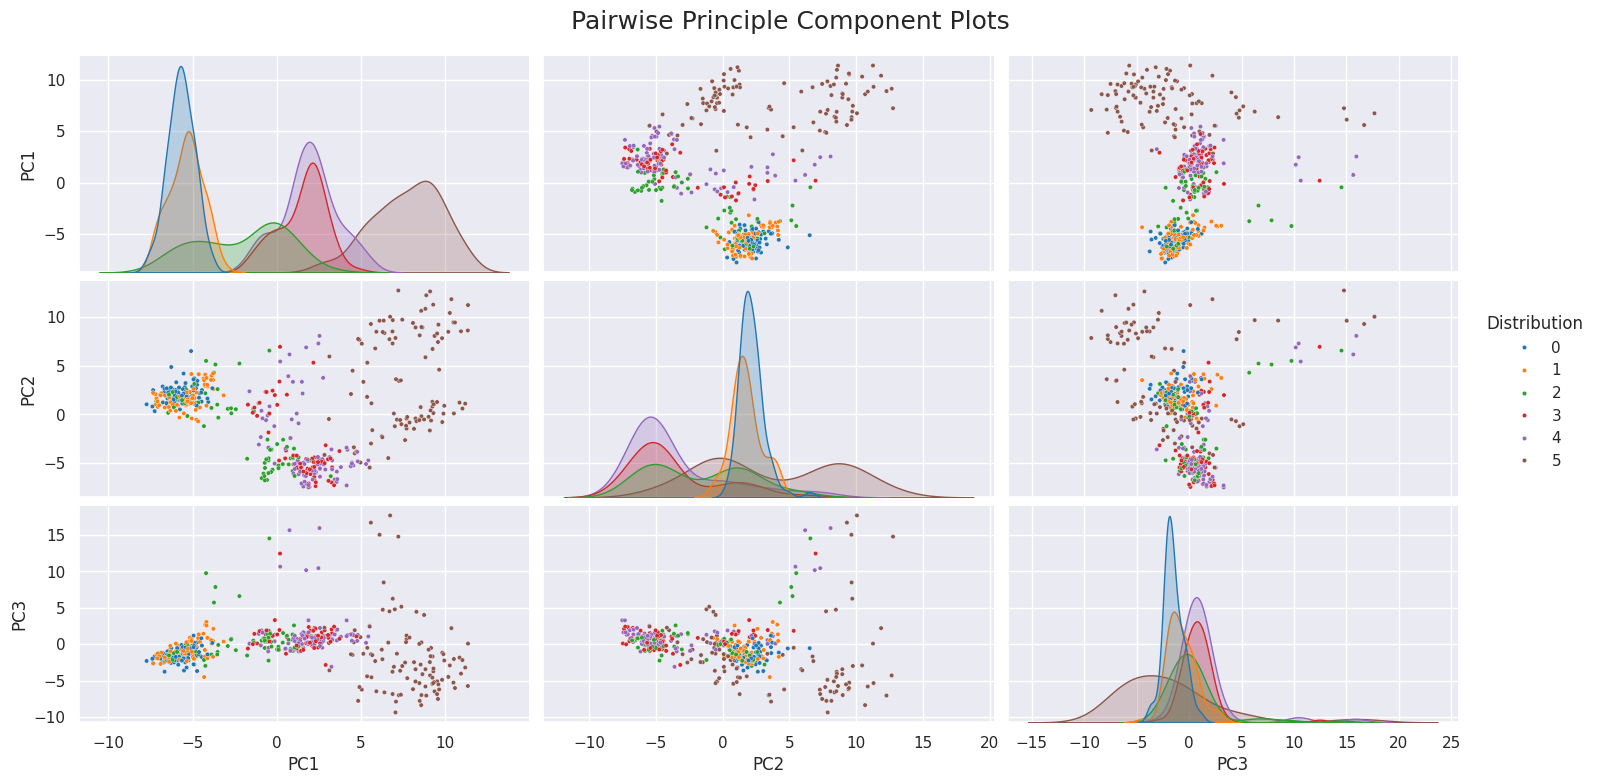

In [25]:
f = sns.pairplot(plot_df,
                 hue='Distribution',
                 vars=['PC1', 'PC2', 'PC3'],
                 palette='tab10',
                 aspect=2,
                 plot_kws=dict(s=10))

f.fig.suptitle('Pairwise Principle Component Plots', fontsize=18, y=1.04);